In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
# import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from theano.compile.ops import as_op
from scipy.stats import norm

%matplotlib inline

color = '#87ceeb'
f_dict = {'size':14}

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
data = pd.read_csv('https://osf.io/zftb3/download')
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       36 non-null     int64 
 1   Descrip  36 non-null     object
 2   n1       36 non-null     int64 
 3   n2       36 non-null     int64 
 4   n3       36 non-null     int64 
 5   n4       36 non-null     int64 
 6   n5       36 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 2.1+ KB


In [4]:
data.head()

ID          Descrip   n1   n2   n3    n4    n5
0   1  The Whole Truth   49   70  119   217   245
1   2        Priceless   67   22   22    60   574
2   3           Allied   59   76  102   203   406
3   4  The Infiltrator  173  216  518  1339  2073
4   5      Miss Sloane  180   60   48   120   793

In [5]:
# Columns n1 - n5
y = data.iloc[:,2:]

In [6]:
# Number of outcomes
nYlevels = y.columns.size
nYlevels



5

In [7]:
Ncases = y.index.size
Ncases

36

In [8]:
z = y.sum(1)
z.head()



0     700
1     745
2     846
3    4319
4    1201
dtype: int64

In [9]:
gammaShRa = gammaShRaFromModeSD(3,3)
gammaShRa



(2.618033988749895, 0.5393446629166316)

In [10]:
# Thresholds, masking the the inner two values. 
thresh = [k + .5 for k in range(1, nYlevels)]
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5, 2.5, 3.5, 4.5]
thresh_obs:	[1.5 -- -- 4.5]


In [11]:


@as_op(itypes=[tt.dvector, tt.dvector, tt.dvector], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((nYlevels, Ncases), dtype=np.float64)
    n = norm(loc=mu, scale=sigma)
    lbound = np.repeat(0, Ncases)
    
    # Thresholded cumulative normal probabilities.
    # Four thresholds (theta values) define the 5 outcome probabilities.
    out[0,:] = n.cdf(theta[0])        
    out[1,:] = np.max([lbound, n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[2,:] = np.max([lbound, n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[3,:] = np.max([lbound, n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[4,:] = 1 - n.cdf(theta[3])

    return out



In [16]:
# Model a hierarchical sigma?
hierarchSD = False

with pm.Model() as ordinal_model_multi_groups:    
    # Latent means (rating) of the movies           
    mu = pm.Normal('mu', mu=(1+nYlevels)/2.0, tau=1.0/(nYlevels)**2, shape=Ncases)
    
    # Latent standard deviations of the ratings.
    if hierarchSD:
        sigmaSD = pm.Gamma('sigmaSD', gammaShRa[0], gammaShRa[1])
        sigmaMode = pm.Gamma('sigmaMode', gammaShRa[0], gammaShRa[1])
    else:
        sigmaSD = 3.0
        sigmaMode = 3.0
    sigmaRa = pm.Deterministic('sigmaRa', ((sigmaMode + pm.math.sqrt(sigmaMode**2 + 4*sigmaSD**2)) / (2*sigmaSD**2)))
    sigmaSh = pm.Deterministic('sigmaSh', 1 + sigmaMode*sigmaRa)
    sigma = pm.Gamma('sigma', sigmaSh, sigmaRa, shape=Ncases)
    
    # Latent thresholds between the ratings (ordinal values)
    theta = pm.Normal('theta', mu=thresh, tau=1/np.repeat(2**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs)
    
    # Cumulative normal probabilities for ratings (ordinal values)
    pr = outcome_probabilities(theta, mu, sigma)
    
    # Likelihood
    out = pm.Multinomial('out', n=z, p=pr.T, observed=y.values)
    

In [17]:
with ordinal_model_multi_groups:       
    trace = pm.sample(400, cores=4, progressbar=True)

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [theta_missing]
>Slice: [sigma]
>Slice: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [13:39<00:00,  4.39draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


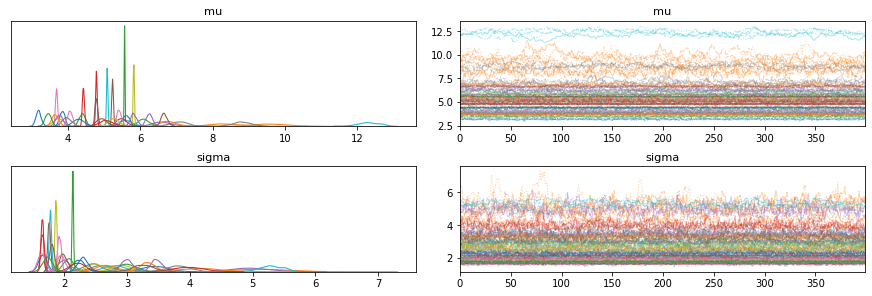

In [19]:
fig1 = pm.traceplot(trace, ['mu', 'sigma'], compact=True,combined=True)

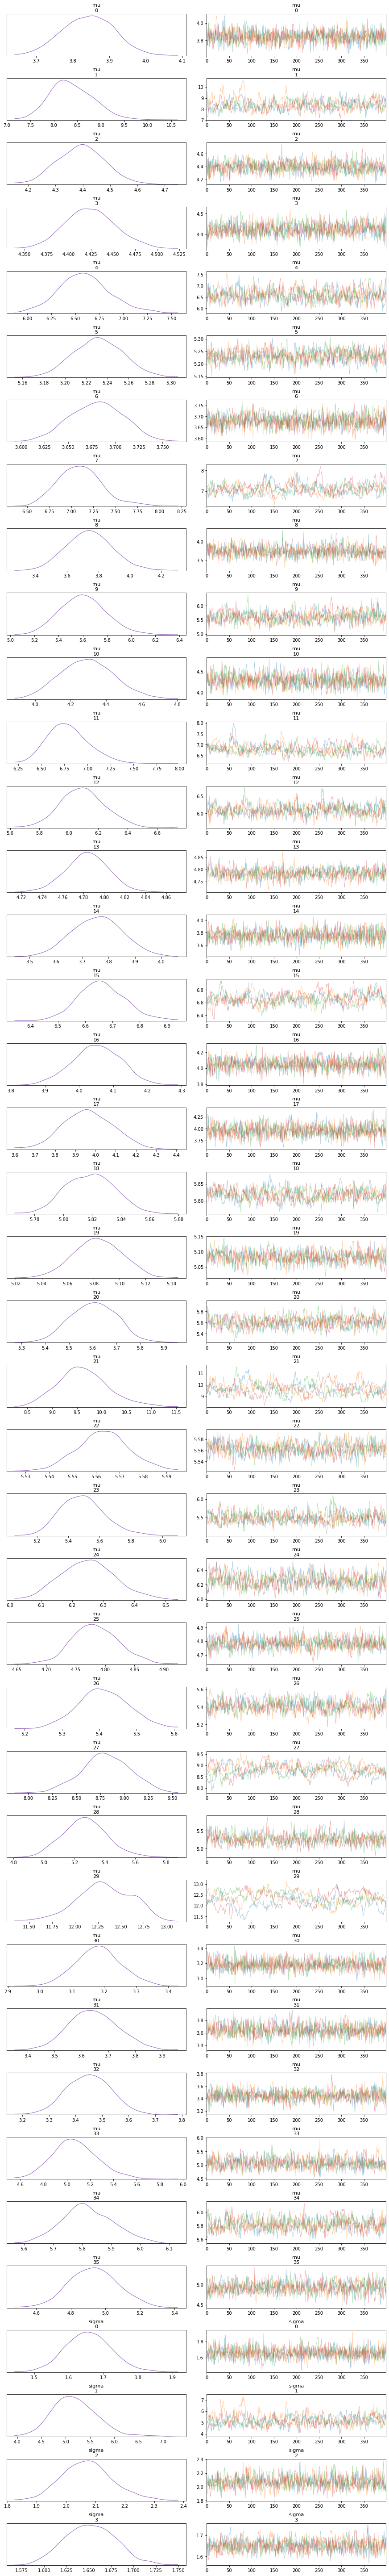

In [20]:
fig2 = pm.traceplot(trace, ['mu', 'sigma'], compact=False,combined=True)

In [15]:
plt.savefig(fig1, "traceplot.jpg")

TypeError: savefig() takes 2 positional arguments but 3 were given

In [ ]:
pm.summary(trace, ['theta_missing'])

In [ ]:
3+3